In [2]:
import time
import datetime
import os
import csv
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from collections import OrderedDict
from typing import Tuple, List

def evaluate_model(interpreter: tf.lite.Interpreter, test_images, test_labels) -> Tuple[float, float]:
    """ Evaluate TFLite Model:
    -
    Receives the interpreter and returns a tuple of loss and accuracy.
    """
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    predictions = []
    for i, test_image in enumerate(test_images):
        # Pre-processing: add batch dimension and convert to float32 to match with the model's input data format.
        test_image = np.expand_dims(test_image, axis = 0).astype(np.float32)
        test_image = np.expand_dims(test_image, axis = 3).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        predictions.append(np.copy(output()[0]))
        prediction_digits.append(digit)

    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    predictions = np.array(predictions)
    scce = tf.keras.losses.SparseCategoricalCrossentropy()(test_labels, predictions)

    loss = scce.numpy()
    accuracy = (prediction_digits == test_labels).mean()
    return loss, accuracy

def prob_mass_gen(bits : int) -> Tuple[List[int], List[float]]:
    """ Discrete triangular distribution
    -
    - Receives the number of bits and calculates the probability mass function """
    values = np.arange(0, bits)
    n = len(values)
    p_max = 2/n
    m_max = p_max/(n - 1)
    # Probability calculation
    p = p_max * 1.0
    m = 2/(n - 1)*(p - 1/n)
    probabilities = [p + m*(i - values[-1]) for i in values]
    return values, probabilities

def random_bit_flipper(value : int) -> Tuple[int, int]:
    """ Random bit flipper 
    -
    Obtains a value and flips one bit at a random position according to a triangular distribution.
    - All values are in 8 bits, MSB have higher probability of getting flipped
    - It is assumed value is a signed 8 bit number """
    bits, probs = prob_mass_gen(8)
    bit_pos = np.random.choice(bits, p = probs)
    # Negative 2 Complement conversion
    if value < 0:
        value = (-value ^ 0xFF) + 1
    flip_mask = 1 << bit_pos
    flipped_value = value ^ flip_mask
    # Negative back conversion 2 Complement
    if flipped_value >= 128:
        flipped_value = -((flipped_value ^ 0xFF) + 1)
    return bit_pos, flipped_value

def random_bit_flipper_uniform(value : int) -> Tuple[int, int]:
    """ Random bit flipper with uniform distribution
    -
    Obtains a value and flips one bit at a random position according to a uniform distribution.
    - All values are in 8 bits, every bit has the same probability of getting flipped
    - It is assumed value is a signed 8 bit number """
    bit_pos = np.random.randint(8)
    # Negative 2 Complement conversion
    if value < 0:
        value = (-value ^ 0xFF) + 1
    flip_mask = 1 << bit_pos
    flipped_value = value ^ flip_mask
    # Negative back conversion 2 Complement
    if flipped_value >= 128:
        flipped_value = -((flipped_value ^ 0xFF) + 1)
    return bit_pos, flipped_value

def n_bit_flipper(value : int, bit_width: int, bit_pos : int) -> int:
    """ Bit flipper n-bit length
    -
    Obtains a value and flips one bit at the specified position.
    - All values are in n bits
    - It is assumed value is a signed n bit number """
    # Negative 2 Complement conversion
    mask = 2**bit_width - 1
    if value < 0:
        value = (-value ^ mask) + 1
    flip_mask = 1 << bit_pos
    flipped_value = value ^ flip_mask
    # Negative back conversion 2 Complement
    if flipped_value >= 2**(bit_width - 1):
        flipped_value = -((flipped_value ^ mask) + 1)
    return flipped_value

""" Parameters to be tuned:
- Output file name, if you don't update the name manually the previous file won't be deleted. New data will be appended to the end of the file instead.
- Flag that enables training data to be saved, a False flag will decrease running time significantly.
- Flag that enables laplacian related data to be saved.
- Number of simulations per layer.
- Total number of bits that will be flipped randomly from any weight in each layer.
"""


" Parameters to be tuned:\n- Output file name, if you don't update the name manually the previous file won't be deleted. New data will be appended to the end of the file instead.\n- Flag that enables training data to be saved, a False flag will decrease running time significantly.\n- Flag that enables laplacian related data to be saved.\n- Number of simulations per layer.\n- Total number of bits that will be flipped randomly from any weight in each layer.\n"

In [3]:
SAVE_FILE_NAME = 'Performance_Multiple_5.csv'
SAVE_TRAINING_PERFORMANCE_FLAG = False
SAVE_LAPLACIAN_DATA_FLAG = True
N_SIMULATIONS_PER_LAYER = 1
N_BITS_TO_FLIP = 10

MODELS_DIR = "./model/"
LOAD_PATH_Q_AWARE = MODELS_DIR + "model_q_aware_final_01"
LOAD_TFLITE_PATH = MODELS_DIR + 'tflite_final_01.tflite'
SAVE_NEW_TFLITE_PATH = MODELS_DIR + 'new_tflite_flip_01.tflite'
OUTPUTS_DIR = "./outputs/"
SAVE_DATA_PATH = OUTPUTS_DIR + SAVE_FILE_NAME

if not os.path.exists(OUTPUTS_DIR):
    os.mkdir(OUTPUTS_DIR)


In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
print(train_images.shape)
train_images = train_images / 255.0
test_images = test_images / 255.0

# Load Q Aware model
q_aware_model : tf.keras.Model
with tfmot.quantization.keras.quantize_scope():
    q_aware_model = tf.keras.models.load_model(LOAD_PATH_Q_AWARE)
# Load TFLite model
interpreter = tf.lite.Interpreter(LOAD_TFLITE_PATH)

# Evaluate accuracy of both models in test set
q_aware_test_loss, q_aware_test_acc = q_aware_model.evaluate(test_images, test_labels)
print('Q Aware model test accuracy : ', "{:0.2%}".format(q_aware_test_acc))
print('Q Aware model test loss: ', q_aware_test_loss)
interpreter.allocate_tensors()
tflite_test_loss, tflite_test_accuracy = evaluate_model(interpreter, test_images, test_labels)
print('TFLite model test accuracy:', "{:0.2%}".format(tflite_test_accuracy))
print('TFLite model test loss: ', tflite_test_loss)

(60000, 28, 28)
313/313 [==============================] - 2s 5ms/step - loss: 0.2891 - accuracy: 0.9115
Q Aware model test accuracy :  91.15%
Q Aware model test loss:  0.2890910804271698
TFLite model test accuracy: 91.17%
TFLite model test loss:  0.3396423


In [5]:
print("Q Aware model summary")
for i, layer in enumerate(q_aware_model.layers):
    print(i, layer.name, len(layer.variables),"input", layer.input.shape, "output", layer.output.shape)

Q Aware model summary
0 input_1 0 input (None, 28, 28, 1) output (None, 28, 28, 1)
1 quantize_layer 3 input (None, 28, 28, 1) output (None, 28, 28, 1)
2 quant_conv2d 7 input (None, 28, 28, 1) output (None, 24, 24, 32)
3 quant_max_pooling2d 1 input (None, 24, 24, 32) output (None, 12, 12, 32)
4 quant_conv2d_1 7 input (None, 12, 12, 32) output (None, 8, 8, 64)
5 quant_max_pooling2d_1 1 input (None, 8, 8, 64) output (None, 4, 4, 64)
6 quant_conv2d_2 7 input (None, 4, 4, 64) output (None, 2, 2, 96)
7 quant_max_pooling2d_2 1 input (None, 2, 2, 96) output (None, 1, 1, 96)
8 quant_flatten 1 input (None, 1, 1, 96) output (None, 96)
9 quant_dense_last 7 input (None, 96) output (None, 10)


In [6]:
TARGET_LAYER = 2
for variable in q_aware_model.layers[TARGET_LAYER].variables:
    print(variable.name)
vars = [var.numpy() for var in q_aware_model.layers[TARGET_LAYER].non_trainable_variables[-2:]]
print(vars)

conv2d/kernel:0
conv2d/bias:0
quant_conv2d/optimizer_step:0
quant_conv2d/kernel_min:0
quant_conv2d/kernel_max:0
quant_conv2d/post_activation_min:0
quant_conv2d/post_activation_max:0
[-3.9335735, 4.380244]


In [7]:
print("Trainable")
for i, layer in enumerate(q_aware_model.layers):
    for variable in layer.trainable_variables:
        print(i, layer.name, variable.name)

Trainable
2 quant_conv2d conv2d/kernel:0
2 quant_conv2d conv2d/bias:0
4 quant_conv2d_1 conv2d_1/kernel:0
4 quant_conv2d_1 conv2d_1/bias:0
6 quant_conv2d_2 conv2d_2/kernel:0
6 quant_conv2d_2 conv2d_2/bias:0
9 quant_dense_last dense_last/kernel:0
9 quant_dense_last dense_last/bias:0


In [8]:
print("Non trainable")
for i, layer in enumerate(q_aware_model.layers):
    for variable in layer.non_trainable_variables:
        print(i, layer.name, variable.name)

Non trainable
1 quantize_layer quantize_layer/quantize_layer_min:0
1 quantize_layer quantize_layer/quantize_layer_max:0
1 quantize_layer quantize_layer/optimizer_step:0
2 quant_conv2d quant_conv2d/optimizer_step:0
2 quant_conv2d quant_conv2d/kernel_min:0
2 quant_conv2d quant_conv2d/kernel_max:0
2 quant_conv2d quant_conv2d/post_activation_min:0
2 quant_conv2d quant_conv2d/post_activation_max:0
3 quant_max_pooling2d quant_max_pooling2d/optimizer_step:0
4 quant_conv2d_1 quant_conv2d_1/optimizer_step:0
4 quant_conv2d_1 quant_conv2d_1/kernel_min:0
4 quant_conv2d_1 quant_conv2d_1/kernel_max:0
4 quant_conv2d_1 quant_conv2d_1/post_activation_min:0
4 quant_conv2d_1 quant_conv2d_1/post_activation_max:0
5 quant_max_pooling2d_1 quant_max_pooling2d_1/optimizer_step:0
6 quant_conv2d_2 quant_conv2d_2/optimizer_step:0
6 quant_conv2d_2 quant_conv2d_2/kernel_min:0
6 quant_conv2d_2 quant_conv2d_2/kernel_max:0
6 quant_conv2d_2 quant_conv2d_2/post_activation_min:0
6 quant_conv2d_2 quant_conv2d_2/post_activ

In [9]:
input_layer = tf.keras.layers.Input(shape = (28, 28, 1))
conv_1 = tf.keras.layers.Conv2D(32, 5, use_bias = True, activation = 'relu')(input_layer)

input_layer_2 = tf.keras.layers.Input(shape = (24, 24, 32))
pool_1 = tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2)(input_layer_2)
conv_2 = tf.keras.layers.Conv2D(64, 5, use_bias = True, activation = 'relu')(pool_1)
pool_2 = tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2)(conv_2)
conv_3 = tf.keras.layers.Conv2D(96, 3, use_bias = True, activation = 'relu')(pool_2)
pool_3 = tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2)(conv_3)
flat_1 = tf.keras.layers.Flatten()(pool_3)
dense_out = tf.keras.layers.Dense(10, activation = 'softmax', name = "dense_last")(flat_1)

nq_model_part1 = tf.keras.models.Model(inputs = input_layer, outputs = conv_1)
nq_model_part2 = tf.keras.models.Model(inputs = input_layer_2, outputs = dense_out)

In [10]:
# Quantification of values
BIT_WIDTH = 8
quantized_and_dequantized = OrderedDict()
quantized = OrderedDict()
layer_index_list = []
keys_list = []
layers_shapes = []

layer : tfmot.quantization.keras.QuantizeWrapperV2
for i, layer in enumerate(q_aware_model.layers):
    quantizer : tfmot.quantization.keras.quantizers.Quantizer
    weight : tf.Variable
    if hasattr(layer, '_weight_vars'):
        for weight, quantizer, quantizer_vars in layer._weight_vars:
            min_var = quantizer_vars['min_var']
            max_var = quantizer_vars['max_var']
            
            key = weight.name[:-2]
            layer_index_list.append(i)
            keys_list.append(key)
            layers_shapes.append(weight.numpy().shape)
            quantized_and_dequantized[key] = quantizer(inputs = weight, training = False, weights = quantizer_vars)
            quantized[key] = np.round(quantized_and_dequantized[key] / max_var * (2**(BIT_WIDTH-1)-1))

In [11]:
# Extraction of all scales and quantized values
T_VARIABLES_KERNEL_INDEX = 0
T_VARIABLES_BIAS_INDEX = 1
new_layer_index_list = []
new_keys_list = []
input_scales = OrderedDict()
kernel_scales = OrderedDict()
bias_scales = OrderedDict()
output_scales = OrderedDict()

kernel_max_vars = OrderedDict()
kernel_min_vars = OrderedDict()
quantized_bias = OrderedDict()
quantized_and_dequantized_weights = OrderedDict()
quantized_weights = OrderedDict()

for i, layer in enumerate(q_aware_model.layers):
    layer_flag = False
    for nt_variable in layer.non_trainable_variables:
        if ("quantize_layer" in nt_variable.name or "kernel" in nt_variable.name) and not layer_flag:
            new_layer_index_list.append(i)
            new_keys_list.append(layer.name)
            layer_flag = True

for i, index in enumerate(new_layer_index_list):
    key = new_keys_list[i]
    for nt_variable in q_aware_model.layers[index].non_trainable_variables:
        # First layer (Quantization Layer) does not have input scale
        if i == 0:
            if "quantize_layer" in nt_variable.name and "min" in nt_variable.name:
                min_var = nt_variable
            if "quantize_layer" in nt_variable.name and "max" in nt_variable.name:
                max_var = nt_variable
        else:
            if "activation_min" in nt_variable.name:
                min_var = nt_variable
            if "activation_max" in nt_variable.name:
                max_var = nt_variable
            if "kernel_min" in nt_variable.name:
                kernel_min_var = nt_variable
            if "kernel_max" in nt_variable.name:
                kernel_max_var = nt_variable
    if i != 0:
        kernel_max_vars[key] = kernel_max_var
        kernel_min_vars[key] = kernel_min_var
        input_scales[key] = output_scales[new_keys_list[i - 1]]
        kernel_scales[key] = (kernel_max_var - kernel_min_var).numpy()/(2**BIT_WIDTH - 2)
        bias_scales[key] = input_scales[key]*kernel_scales[key]
    output_scales[key] = ((max_var - min_var).numpy()/(2**BIT_WIDTH - 1)).astype(np.float32)


for i, index in enumerate(new_layer_index_list):
    key = new_keys_list[i]
    if len(q_aware_model.layers[index].trainable_variables) != 0:
        quantized_bias[key] = np.round(q_aware_model.layers[index].trainable_variables[T_VARIABLES_BIAS_INDEX].numpy()/bias_scales[key]).astype(int)
        if "conv2d" in key:
            quantized_and_dequantized_weights[key] = tf.quantization.fake_quant_with_min_max_vars_per_channel(q_aware_model.layers[index].trainable_variables[T_VARIABLES_KERNEL_INDEX], kernel_min_vars[key], kernel_max_vars[key], BIT_WIDTH, narrow_range = True)
        elif "dense" in key:
            quantized_and_dequantized_weights[key] = tf.quantization.fake_quant_with_min_max_vars(q_aware_model.layers[index].trainable_variables[T_VARIABLES_KERNEL_INDEX], kernel_min_vars[key], kernel_max_vars[key], BIT_WIDTH, narrow_range = True)
        quantized_weights[key] = np.round(quantized_and_dequantized_weights[key] / kernel_scales[key]).astype(int)
        # quantized_weights[key] = np.round(q_aware_model.layers[index].trainable_variables[T_VARIABLES_KERNEL_INDEX].numpy()/kernel_scales[key]).astype(int) # Does not work properly

# print(new_keys_list)
# print(new_layer_index_list)

# print("Input scales", input_scales)
# print("Output scales", output_scales)
# print("Kernel scales", kernel_scales)
# print("Bias scales", bias_scales)

# print("Quantized weights difference", np.unique(quantized_weights[new_keys_list[4]] - quantized[keys_list[3]]))
# print("Quantized weights", quantized_weights)
# print("Quantized biases", quantized_bias)

print(kernel_min_vars[new_keys_list[1]].dtype)
print(kernel_max_vars[new_keys_list[1]].dtype)
print(input_scales[new_keys_list[1]].dtype)
print(kernel_scales[new_keys_list[1]].dtype)
print(bias_scales[new_keys_list[1]].dtype)
print(output_scales[new_keys_list[1]].dtype)

<dtype: 'float32'>
<dtype: 'float32'>
float32
float32
float32
float32


In [12]:
print("Part 1 Summary")
for i, layer in enumerate(nq_model_part1.layers):
    print(i, layer.name, len(layer.variables),"input", layer.input.shape, "output", layer.output.shape)
print("Part 2 Summary")
for i, layer in enumerate(nq_model_part2.layers):
    print(i, layer.name, len(layer.variables),"input", layer.input.shape, "output", layer.output.shape)

Part 1 Summary
0 input_1 0 input (None, 28, 28, 1) output (None, 28, 28, 1)
1 conv2d 2 input (None, 28, 28, 1) output (None, 24, 24, 32)
Part 2 Summary
0 input_2 0 input (None, 24, 24, 32) output (None, 24, 24, 32)
1 max_pooling2d 0 input (None, 24, 24, 32) output (None, 12, 12, 32)
2 conv2d_1 2 input (None, 12, 12, 32) output (None, 8, 8, 64)
3 max_pooling2d_1 0 input (None, 8, 8, 64) output (None, 4, 4, 64)
4 conv2d_2 2 input (None, 4, 4, 64) output (None, 2, 2, 96)
5 max_pooling2d_2 0 input (None, 2, 2, 96) output (None, 1, 1, 96)
6 flatten 0 input (None, 1, 1, 96) output (None, 96)
7 dense_last 2 input (None, 96) output (None, 10)


In [13]:
print("Part 1 Trainable")
for i, layer in enumerate(nq_model_part1.layers):
    for variable in layer.trainable_variables:
        print(i, layer.name, variable.name)
print("Part 1 Non Trainable")
for i, layer in enumerate(nq_model_part1.layers):
    for variable in layer.non_trainable_variables:
        print(i, layer.name, variable.name)
print("Part 2 Trainable")
for i, layer in enumerate(nq_model_part2.layers):
    for variable in layer.trainable_variables:
        print(i, layer.name, variable.name)
print("Part 2 Non Trainable")
for i, layer in enumerate(nq_model_part2.layers):
    for variable in layer.non_trainable_variables:
        print(i, layer.name, variable.name)

Part 1 Trainable
1 conv2d conv2d/kernel:0
1 conv2d conv2d/bias:0
Part 1 Non Trainable
Part 2 Trainable
2 conv2d_1 conv2d_1/kernel:0
2 conv2d_1 conv2d_1/bias:0
4 conv2d_2 conv2d_2/kernel:0
4 conv2d_2 conv2d_2/bias:0
7 dense_last dense_last/kernel:0
7 dense_last dense_last/bias:0
Part 2 Non Trainable


In [14]:
print(layer_index_list)
indexes_part1 = [1]
indexes_part2 = [2, 4, 7]
weights_1 = q_aware_model.layers[layer_index_list[0]].get_weights()
weights_2 = [q_aware_model.layers[idx].get_weights() for idx in layer_index_list[1:]]
# print([variable.name for variable in q_aware_model.layers[layer_index_list[0]].trainable_variables])
for idx in indexes_part1:
    nq_model_part1.layers[idx].set_weights(weights_1[:2])
for i, idx in enumerate(indexes_part2):
    nq_model_part2.layers[idx].set_weights(weights_2[i][:2])

print(q_aware_model.layers[layer_index_list[0]].trainable_variables[0][:3,:3,0,5].numpy())
print(nq_model_part1.layers[1].variables[0][:3,:3,0,5].numpy())
print(q_aware_model.layers[layer_index_list[0]].trainable_variables[1][:5].numpy())
print(nq_model_part1.layers[1].variables[1][:5].numpy())

print(q_aware_model.layers[layer_index_list[2]].trainable_variables[0][:3,:3,0,15].numpy())
print(nq_model_part2.layers[4].variables[0][:3,:3,0,15].numpy())
print(q_aware_model.layers[layer_index_list[2]].trainable_variables[1][:5].numpy())
print(nq_model_part2.layers[4].variables[1][:5].numpy())

[2, 4, 6, 9]
[[-0.07918215 -0.01161032  0.07245282]
 [ 0.00061669 -0.22089666 -0.01293123]
 [ 0.03844265  0.06296697  0.14747679]]
[[-0.07918215 -0.01161032  0.07245282]
 [ 0.00061669 -0.22089666 -0.01293123]
 [ 0.03844265  0.06296697  0.14747679]]
[ 0.02969096  0.01373224 -0.25231063 -0.01235129 -0.03170829]
[ 0.02969096  0.01373224 -0.25231063 -0.01235129 -0.03170829]
[[ 0.00423666 -0.10165723 -0.21178155]
 [-0.1674046  -0.30126658 -0.01047609]
 [-0.1538336  -0.02137352 -0.08994394]]
[[ 0.00423666 -0.10165723 -0.21178155]
 [-0.1674046  -0.30126658 -0.01047609]
 [-0.1538336  -0.02137352 -0.08994394]]
[-0.0156321  -0.01641378 -0.03496066 -0.13640228  0.00386511]
[-0.0156321  -0.01641378 -0.03496066 -0.13640228  0.00386511]


train images shape (60000, 28, 28)
out images shape (1, 24, 24, 32)


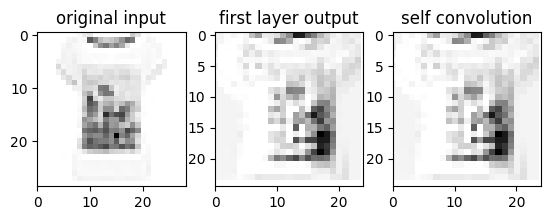

[[0.02695452 0.02885798 0.00449268 0.02263477]
 [0.03401939 0.024934   0.00543544 0.        ]
 [0.04594108 0.         0.0026864  0.        ]
 [0.02412694 0.         0.         0.        ]]
[[0.02695452 0.02885798 0.00449269 0.02263477]
 [0.0340194  0.024934   0.00543544 0.        ]
 [0.04594108 0.         0.0026864  0.        ]
 [0.02412694 0.         0.         0.        ]]


In [15]:
# Test to replicate the behaviour of first layer
TARGET_IMAGE = 1074
TARGET_LAYER_FOO = 1
T_VARIABLES_KERNEL_INDEX = 0
T_VARIABLES_BIAS_INDEX = 1
OUT_CHANNEL = 23

foo_image = np.zeros((28,28))
foo_image[4,4] = 1

out = nq_model_part1(train_images[np.newaxis,TARGET_IMAGE])
# out = nq_model_part1(foo_image[np.newaxis])

kernel = nq_model_part1.layers[TARGET_LAYER_FOO].trainable_variables[T_VARIABLES_KERNEL_INDEX][:,:,0,OUT_CHANNEL].numpy()
bias = nq_model_part1.layers[TARGET_LAYER_FOO].trainable_variables[T_VARIABLES_BIAS_INDEX][OUT_CHANNEL].numpy()

# self_conv = sp.signal.correlate2d(foo_image, kernel, mode = "valid") + bias
self_conv = sp.signal.correlate2d(train_images[TARGET_IMAGE], kernel, mode = "valid") + bias
self_conv = np.maximum(0, self_conv)
print("train images shape", train_images.shape)
print("out images shape", out.shape)

fig, ax = plt.subplots(1, 3, figsize = (6.5, 2))
ax[0].imshow(train_images[TARGET_IMAGE], cmap = 'Greys')
# ax[0].imshow(foo_image, cmap = 'Greys')
ax[0].set_title('original input')
ax[0].axis('equal')
ax[0].set(xlim = (0, train_images.shape[-2:][0]), ylim = (train_images.shape[-2:][1], 0))

ax[1].imshow(out[0,:,:,OUT_CHANNEL], cmap = 'Greys')
ax[1].set_title('first layer output')
ax[1].axis('equal')
ax[1].set(xlim = (0, out.shape[1:3][0]), ylim = (out.shape[1:3][1], 0))

ax[2].imshow(self_conv, cmap = 'Greys')
ax[2].set_title('self convolution')
ax[2].axis('equal')
ax[2].set(xlim = (0, out.shape[1:3][0]), ylim = (out.shape[1:3][1], 0))
plt.show()
plt.close()

slicer = slice(None,4)
print(self_conv[(slicer,slicer)])
print(out[(0,slicer,slicer,OUT_CHANNEL)].numpy())

In [16]:
KERNEL_INDEX = 0
BIAS_INDEX = 1
original_layer_vars = [[variable.numpy() for variable in q_aware_model.layers[idx].trainable_variables] for idx in layer_index_list]

print(np.unique((nq_model_part1.layers[indexes_part1[0]].variables[KERNEL_INDEX] - original_layer_vars[0][KERNEL_INDEX]).numpy()),
np.unique((nq_model_part1.layers[indexes_part1[0]].variables[BIAS_INDEX] - original_layer_vars[0][BIAS_INDEX]).numpy()),

np.unique((nq_model_part2.layers[indexes_part2[0]].variables[KERNEL_INDEX] - original_layer_vars[1][KERNEL_INDEX]).numpy()),
np.unique((nq_model_part2.layers[indexes_part2[0]].variables[BIAS_INDEX] - original_layer_vars[1][BIAS_INDEX]).numpy()),

np.unique((nq_model_part2.layers[indexes_part2[1]].variables[KERNEL_INDEX] - original_layer_vars[2][KERNEL_INDEX]).numpy()),
np.unique((nq_model_part2.layers[indexes_part2[1]].variables[BIAS_INDEX] - original_layer_vars[2][BIAS_INDEX]).numpy()),

np.unique((nq_model_part2.layers[indexes_part2[1]].variables[KERNEL_INDEX] - original_layer_vars[2][KERNEL_INDEX]).numpy()),
np.unique((nq_model_part2.layers[indexes_part2[1]].variables[BIAS_INDEX] - original_layer_vars[2][BIAS_INDEX]).numpy()),

np.unique((nq_model_part2.layers[indexes_part2[2]].variables[KERNEL_INDEX] - original_layer_vars[3][KERNEL_INDEX]).numpy()),
np.unique((nq_model_part2.layers[indexes_part2[2]].variables[BIAS_INDEX] - original_layer_vars[3][BIAS_INDEX]).numpy()),
)

[0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.]


In [17]:
q_model_part1 = tfmot.quantization.keras.quantize_model(nq_model_part1)
q_model_part2 = tfmot.quantization.keras.quantize_model(nq_model_part2)
print("Q Part 1 Summary")
for i, layer in enumerate(q_model_part1.layers):
    print(i, layer.name, "vars", len(layer.variables),"input", layer.input.shape, "output", layer.output.shape)
print("Q Part 2 Summary")
for i, layer in enumerate(q_model_part2.layers):
    print(i, layer.name, "vars", len(layer.variables),"input", layer.input.shape, "output", layer.output.shape)

Q Part 1 Summary
0 input_1 vars 0 input (None, 28, 28, 1) output (None, 28, 28, 1)
1 quantize_layer vars 3 input (None, 28, 28, 1) output (None, 28, 28, 1)
2 quant_conv2d vars 7 input (None, 28, 28, 1) output (None, 24, 24, 32)
Q Part 2 Summary
0 input_2 vars 0 input (None, 24, 24, 32) output (None, 24, 24, 32)
1 quantize_layer_1 vars 3 input (None, 24, 24, 32) output (None, 24, 24, 32)
2 quant_max_pooling2d vars 1 input (None, 24, 24, 32) output (None, 12, 12, 32)
3 quant_conv2d_1 vars 7 input (None, 12, 12, 32) output (None, 8, 8, 64)
4 quant_max_pooling2d_1 vars 1 input (None, 8, 8, 64) output (None, 4, 4, 64)
5 quant_conv2d_2 vars 7 input (None, 4, 4, 64) output (None, 2, 2, 96)
6 quant_max_pooling2d_2 vars 1 input (None, 2, 2, 96) output (None, 1, 1, 96)
7 quant_flatten vars 1 input (None, 1, 1, 96) output (None, 96)
8 quant_dense_last vars 7 input (None, 96) output (None, 10)


In [18]:
print("Part 1 Trainable")
for i, layer in enumerate(q_model_part1.layers):
    for variable in layer.trainable_variables:
        print(i, layer.name, variable.name)
print("Part 2 Trainable")
for i, layer in enumerate(q_model_part2.layers):
    for variable in layer.trainable_variables:
        print(i, layer.name, variable.name)

Part 1 Trainable
2 quant_conv2d conv2d/kernel:0
2 quant_conv2d conv2d/bias:0
Part 2 Trainable
3 quant_conv2d_1 conv2d_1/kernel:0
3 quant_conv2d_1 conv2d_1/bias:0
5 quant_conv2d_2 conv2d_2/kernel:0
5 quant_conv2d_2 conv2d_2/bias:0
8 quant_dense_last dense_last/kernel:0
8 quant_dense_last dense_last/bias:0


In [19]:
print("Part 1 Non Trainable")
for i, layer in enumerate(q_model_part1.layers):
    for variable in layer.non_trainable_variables:
        print(i, layer.name, variable.name)

Part 1 Non Trainable
1 quantize_layer quantize_layer/quantize_layer_min:0
1 quantize_layer quantize_layer/quantize_layer_max:0
1 quantize_layer quantize_layer/optimizer_step:0
2 quant_conv2d quant_conv2d/optimizer_step:0
2 quant_conv2d quant_conv2d/kernel_min:0
2 quant_conv2d quant_conv2d/kernel_max:0
2 quant_conv2d quant_conv2d/post_activation_min:0
2 quant_conv2d quant_conv2d/post_activation_max:0


In [20]:
print("Part 2 Non Trainable")
for i, layer in enumerate(q_model_part2.layers):
    for variable in layer.non_trainable_variables:
        print(i, layer.name, variable.name)

Part 2 Non Trainable
1 quantize_layer_1 quantize_layer_1/quantize_layer_1_min:0
1 quantize_layer_1 quantize_layer_1/quantize_layer_1_max:0
1 quantize_layer_1 quantize_layer_1/optimizer_step:0
2 quant_max_pooling2d quant_max_pooling2d/optimizer_step:0
3 quant_conv2d_1 quant_conv2d_1/optimizer_step:0
3 quant_conv2d_1 quant_conv2d_1/kernel_min:0
3 quant_conv2d_1 quant_conv2d_1/kernel_max:0
3 quant_conv2d_1 quant_conv2d_1/post_activation_min:0
3 quant_conv2d_1 quant_conv2d_1/post_activation_max:0
4 quant_max_pooling2d_1 quant_max_pooling2d_1/optimizer_step:0
5 quant_conv2d_2 quant_conv2d_2/optimizer_step:0
5 quant_conv2d_2 quant_conv2d_2/kernel_min:0
5 quant_conv2d_2 quant_conv2d_2/kernel_max:0
5 quant_conv2d_2 quant_conv2d_2/post_activation_min:0
5 quant_conv2d_2 quant_conv2d_2/post_activation_max:0
6 quant_max_pooling2d_2 quant_max_pooling2d_2/optimizer_step:0
7 quant_flatten quant_flatten/optimizer_step:0
8 quant_dense_last quant_dense_last/optimizer_step:0
8 quant_dense_last quant_dens

In [21]:
# Assignation of values to first divided model both parts quantized
q_indexes_part1 = [1, 2]
q_indexes_part2 = list(range(3, 9 + 1))
q_indexes_part2_2 = list(range(2, 8 + 1))
# for i, layer in enumerate(q_aware_model.layers):
#     # layer.get_weights()
#     if len(layer.get_weights()) != 0:
#         print(i)
q_weights_1 = [q_aware_model.layers[idx].get_weights() for idx in q_indexes_part1]
q_weights_2 = [q_aware_model.layers[idx].get_weights() for idx in q_indexes_part2]
# print(q_weights_1[0])
for i, idx in enumerate(q_indexes_part1):
    q_model_part1.layers[idx].set_weights(q_weights_1[i])
intermediate_max_min = q_aware_model.layers[2].get_weights()[-2:]
intermediate_max_min.append(-1)
q_model_part2.layers[1].set_weights(intermediate_max_min)
for i, idx in enumerate(q_indexes_part2_2):
    q_model_part2.layers[idx].set_weights(q_weights_2[i])

KERNEL_INDEX = 0
BIAS_INDEX = 1
# print(q_model_part1.layers[q_indexes_part1[1]].variables)
# print(q_aware_model.layers[q_indexes_part1[1]].variables)
print(np.unique((q_model_part1.layers[q_indexes_part1[0]].variables[0] - q_aware_model.layers[q_indexes_part1[0]].variables[0]).numpy()),
np.unique((q_model_part1.layers[q_indexes_part1[0]].variables[1] - q_aware_model.layers[q_indexes_part1[0]].variables[1]).numpy()),
np.unique((q_model_part1.layers[q_indexes_part1[0]].variables[2] - q_aware_model.layers[q_indexes_part1[0]].variables[2]).numpy()),

np.unique((q_model_part1.layers[q_indexes_part1[1]].variables[0] - q_aware_model.layers[q_indexes_part1[1]].variables[0]).numpy()),
np.unique((q_model_part1.layers[q_indexes_part1[1]].variables[1] - q_aware_model.layers[q_indexes_part1[1]].variables[1]).numpy()),
np.unique((q_model_part1.layers[q_indexes_part1[1]].variables[2] - q_aware_model.layers[q_indexes_part1[1]].variables[2]).numpy()),
np.unique((q_model_part1.layers[q_indexes_part1[1]].variables[3] - q_aware_model.layers[q_indexes_part1[1]].variables[3]).numpy()),
np.unique((q_model_part1.layers[q_indexes_part1[1]].variables[4] - q_aware_model.layers[q_indexes_part1[1]].variables[4]).numpy()),
np.unique((q_model_part1.layers[q_indexes_part1[1]].variables[5] - q_aware_model.layers[q_indexes_part1[1]].variables[5]).numpy()),
np.unique((q_model_part1.layers[q_indexes_part1[1]].variables[6] - q_aware_model.layers[q_indexes_part1[1]].variables[6]).numpy()),

np.unique(q_model_part2.layers[1].variables[0].numpy()),
np.unique(q_model_part2.layers[1].variables[1].numpy()),
np.unique(q_model_part2.layers[1].variables[2].numpy()),

np.unique((q_model_part2.layers[q_indexes_part2_2[0]].variables[0] - q_aware_model.layers[q_indexes_part2[0]].variables[0]).numpy()),

np.unique((q_model_part2.layers[q_indexes_part2_2[1]].variables[0] - q_aware_model.layers[q_indexes_part2[1]].variables[0]).numpy()),
np.unique((q_model_part2.layers[q_indexes_part2_2[1]].variables[1] - q_aware_model.layers[q_indexes_part2[1]].variables[1]).numpy()),
np.unique((q_model_part2.layers[q_indexes_part2_2[1]].variables[2] - q_aware_model.layers[q_indexes_part2[1]].variables[2]).numpy()),
np.unique((q_model_part2.layers[q_indexes_part2_2[1]].variables[3] - q_aware_model.layers[q_indexes_part2[1]].variables[3]).numpy()),
np.unique((q_model_part2.layers[q_indexes_part2_2[1]].variables[4] - q_aware_model.layers[q_indexes_part2[1]].variables[4]).numpy()),
np.unique((q_model_part2.layers[q_indexes_part2_2[1]].variables[5] - q_aware_model.layers[q_indexes_part2[1]].variables[5]).numpy()),
np.unique((q_model_part2.layers[q_indexes_part2_2[1]].variables[6] - q_aware_model.layers[q_indexes_part2[1]].variables[6]).numpy()),

np.unique((q_model_part2.layers[q_indexes_part2_2[2]].variables[0] - q_aware_model.layers[q_indexes_part2[2]].variables[0]).numpy()),

np.unique((q_model_part2.layers[q_indexes_part2_2[3]].variables[0] - q_aware_model.layers[q_indexes_part2[3]].variables[0]).numpy()),
np.unique((q_model_part2.layers[q_indexes_part2_2[3]].variables[1] - q_aware_model.layers[q_indexes_part2[3]].variables[1]).numpy()),
np.unique((q_model_part2.layers[q_indexes_part2_2[3]].variables[2] - q_aware_model.layers[q_indexes_part2[3]].variables[2]).numpy()),
np.unique((q_model_part2.layers[q_indexes_part2_2[3]].variables[3] - q_aware_model.layers[q_indexes_part2[3]].variables[3]).numpy()),
np.unique((q_model_part2.layers[q_indexes_part2_2[3]].variables[4] - q_aware_model.layers[q_indexes_part2[3]].variables[4]).numpy()),
np.unique((q_model_part2.layers[q_indexes_part2_2[3]].variables[5] - q_aware_model.layers[q_indexes_part2[3]].variables[5]).numpy()),
np.unique((q_model_part2.layers[q_indexes_part2_2[3]].variables[6] - q_aware_model.layers[q_indexes_part2[3]].variables[6]).numpy()),

np.unique((q_model_part2.layers[q_indexes_part2_2[4]].variables[0] - q_aware_model.layers[q_indexes_part2[4]].variables[0]).numpy()),

np.unique((q_model_part2.layers[q_indexes_part2_2[5]].variables[0] - q_aware_model.layers[q_indexes_part2[5]].variables[0]).numpy()),

np.unique((q_model_part2.layers[q_indexes_part2_2[6]].variables[0] - q_aware_model.layers[q_indexes_part2[6]].variables[0]).numpy()),
np.unique((q_model_part2.layers[q_indexes_part2_2[6]].variables[1] - q_aware_model.layers[q_indexes_part2[6]].variables[1]).numpy()),
np.unique((q_model_part2.layers[q_indexes_part2_2[6]].variables[2] - q_aware_model.layers[q_indexes_part2[6]].variables[2]).numpy()),
np.unique((q_model_part2.layers[q_indexes_part2_2[6]].variables[3] - q_aware_model.layers[q_indexes_part2[6]].variables[3]).numpy()),
np.unique((q_model_part2.layers[q_indexes_part2_2[6]].variables[4] - q_aware_model.layers[q_indexes_part2[6]].variables[4]).numpy()),
np.unique((q_model_part2.layers[q_indexes_part2_2[6]].variables[5] - q_aware_model.layers[q_indexes_part2[6]].variables[5]).numpy()),
np.unique((q_model_part2.layers[q_indexes_part2_2[6]].variables[6] - q_aware_model.layers[q_indexes_part2[6]].variables[6]).numpy()),
)

[0.] [0.] [0] [0.] [0.] [0] [0.] [0.] [0.] [0.] [-3.9335735] [4.380244] [-1] [0] [0.] [0.] [0] [0.] [0.] [0.] [0.] [0] [0.] [0.] [0] [0.] [0.] [0.] [0.] [0] [0] [0.] [0.] [0] [0.] [0.] [0.] [0.]


In [22]:
# Test compare inference both original and parts-model
TARGET_IMAGE = 2100
out_original = q_aware_model(train_images[np.newaxis,TARGET_IMAGE])

# Does not yield the same results
out_1 = nq_model_part1(train_images[np.newaxis,TARGET_IMAGE])
out_2 = nq_model_part2(out_1)

# Yields the same results
out_3 = q_model_part1(train_images[np.newaxis,TARGET_IMAGE])
out_4 = q_model_part2(out_3)

print("original output\n", out_original .numpy())
print("non quantized model output\n", out_2.numpy())
print("quantized model output\n", out_4.numpy())
print("\nUnique difference non quantized", np.unique((out_original - out_2).numpy()))
print("Unique difference quantized", np.unique((out_original - out_4).numpy()))

original output
 [[1.8473416e-09 9.9999988e-01 2.5903853e-08 4.0264447e-10 5.8375569e-08
  5.6541989e-12 1.2723472e-08 5.6541989e-12 2.6821853e-10 5.6541989e-12]]
non quantized model output
 [[1.4625762e-15 1.0000000e+00 7.5149568e-15 4.2900803e-17 9.2893006e-14
  1.2390763e-24 2.8898564e-15 5.6050442e-23 1.1157035e-16 4.4603877e-22]]
quantized model output
 [[1.8473416e-09 9.9999988e-01 2.5903853e-08 4.0264447e-10 5.8375569e-08
  5.6541989e-12 1.2723472e-08 5.6541989e-12 2.6821853e-10 5.6541989e-12]]

Unique difference non quantized [-1.1920929e-07  5.6541989e-12  2.6821842e-10  4.0264442e-10
  1.8473402e-09  1.2723469e-08  2.5903846e-08  5.8375477e-08]
Unique difference quantized [0.]


In [23]:
# Extraction of scales and bias of first layer calculation
INPUT_LAYER = 1
CONV1_LAYER = 2
BIT_WIDTH = 8
BIAS_BIT_WIDTH = 32
T_VARIABLES_KERNEL_INDEX = 0
T_VARIABLES_BIAS_INDEX = 1

print(q_aware_model.layers[INPUT_LAYER].name)
vars_input = {variable.name: variable.numpy() for i, variable in enumerate(q_aware_model.layers[INPUT_LAYER].non_trainable_variables) if "min" in variable.name or "max" in variable.name}
# print(vars_input)
quantize_keys_input = [key for key in vars_input if "quantize" in key]
kernel_keys_input = [key for key in vars_input if "kernel" in key]
activation_keys_input = [key for key in vars_input if "activation" in key]
if len(quantize_keys_input) != 0:
    min_quantize_key_input, = tuple(key for key in quantize_keys_input if "min" in key)
    max_quantize_key_input, = tuple(key for key in quantize_keys_input if "max" in key)
else:
    min_quantize_key_input = None
    max_quantize_key_input = None
if len(kernel_keys_input) != 0:
    min_kernel_key_input, = tuple(key for key in kernel_keys_input if "min" in key)
    max_kernel_key_input, = tuple(key for key in kernel_keys_input if "max" in key)
else:
    min_kernel_key_input = None
    max_kernel_key_input = None
if len(activation_keys_input) != 0:
    min_activ_key_input, = tuple(key for key in activation_keys_input if "min" in key)
    max_activ_key_input, = tuple(key for key in activation_keys_input if "max" in key)
else:
    min_activ_key_input = None
    max_activ_key_input = None

print(q_aware_model.layers[CONV1_LAYER].name)
vars_conv1 = {variable.name: variable.numpy() for i, variable in enumerate(q_aware_model.layers[CONV1_LAYER].non_trainable_variables) if "min" in variable.name or "max" in variable.name}
# print(vars_conv1)
quantize_keys_conv1 = [key for key in vars_conv1 if "quantize" in key]
kernel_keys_conv1 = [key for key in vars_conv1 if "kernel" in key]
activation_keys_conv1 = [key for key in vars_conv1 if "activation" in key]
if len(quantize_keys_conv1) != 0:
    min_quantize_key_conv1, = tuple(key for key in quantize_keys_conv1 if "min" in key)
    max_quantize_key_conv1, = tuple(key for key in quantize_keys_conv1 if "max" in key)
else:
    min_quantize_key_conv1 = None
    max_quantize_key_conv1 = None
if len(kernel_keys_conv1) != 0:
    min_kernel_key_conv1, = tuple(key for key in kernel_keys_conv1 if "min" in key)
    max_kernel_key_conv1, = tuple(key for key in kernel_keys_conv1 if "max" in key)
else:
    min_kernel_key_conv1 = None
    max_kernel_key_conv1 = None
if len(activation_keys_conv1) != 0:
    min_activ_key_conv1, = tuple(key for key in activation_keys_conv1 if "min" in key)
    max_activ_key_conv1, = tuple(key for key in activation_keys_conv1 if "max" in key)
else:
    min_activ_key_conv1 = None
    max_activ_key_conv1 = None

input_min = vars_input.get(min_quantize_key_input)
input_max = vars_input.get(max_quantize_key_input)
kernel_min = vars_conv1.get(min_kernel_key_conv1)
kernel_max = vars_conv1.get(max_kernel_key_conv1)
activation_min = vars_conv1.get(min_activ_key_conv1)
activation_max = vars_conv1.get(max_activ_key_conv1)

# Input scales and zeros
input_scale = (input_max - input_min) / (2**BIT_WIDTH - 1)
input_zero = np.round(2**(BIT_WIDTH - 1) - 1 - input_max/input_scale).astype(int)
# Kernel and biases scales
# kernel_scales = (kernel_max - kernel_min) / (2**BIT_WIDTH - 2)
kernel_scales = kernel_max / (2**(BIT_WIDTH - 1) - 1)
bias_scales_first_layer = input_scale * kernel_scales
# Output scale and zero
activation_scale = (activation_max - activation_min) / (2**BIT_WIDTH - 1)
activation_zero = np.round(2**(BIT_WIDTH - 1) - 1 - activation_max/activation_scale).astype(int)

print("input scale", input_scale)
print("input zero", input_zero)
print("kernel scales", kernel_scales)
print("bias scales", bias_scales_first_layer)
print("activation scale", activation_scale)
print("activation zero", activation_zero)

bias_ints = np.round(q_aware_model.layers[CONV1_LAYER].trainable_variables[T_VARIABLES_BIAS_INDEX].numpy() / bias_scales_first_layer).astype(int)
print("bias", bias_ints)
print("bias", [hex(bias) if bias > 0 else hex((-bias ^ 0xFFFFFFFF) + 1) for bias in bias_ints])


quantize_layer
quant_conv2d
input scale 0.00392156862745098
input zero -128
kernel scales [0.00329171 0.00318886 0.00154461 0.00221212 0.00216033 0.00173925
 0.00257462 0.00135561 0.00259043 0.00228444 0.01463084 0.00207081
 0.00626407 0.00238244 0.01474832 0.00248384 0.00260051 0.00279522
 0.00929473 0.002684   0.00207167 0.0020169  0.00217691 0.00185296
 0.00304491 0.00207702 0.0010245  0.00203166 0.00265791 0.00135298
 0.00273699 0.00247921]
bias scales [1.2908661e-05 1.2505331e-05 6.0573111e-06 8.6749860e-06 8.4718740e-06
 6.8206023e-06 1.0096539e-05 5.3161089e-06 1.0158549e-05 8.9585819e-06
 5.7375863e-05 8.1208136e-06 2.4564994e-05 9.3428880e-06 5.7836533e-05
 9.7405646e-06 1.0198080e-05 1.0961662e-05 3.6449925e-05 1.0525496e-05
 8.1241951e-06 7.9094089e-06 8.5368883e-06 7.2664952e-06 1.1940828e-05
 8.1451790e-06 4.0176528e-06 7.9673073e-06 1.0423187e-05 5.3058229e-06
 1.0733294e-05 9.7224120e-06]
activation scale 0.03260320401659199
activation zero -7
bias [  2300   1098 -41654 

[[-128   33   19   32   42]
 [-126   47   18   17   40]
 [ -93   49   27   12   23]
 [ -69   42   25   13   -8]
 [ -49   17   32   86   -5]]
Unique difference between image and quantized and dequantized image [0.00000000e+00 2.77555756e-17 5.55111512e-17 1.11022302e-16]


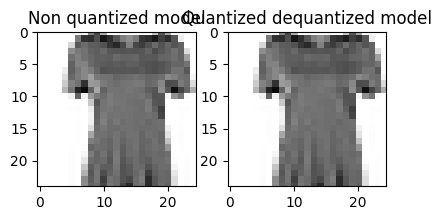

In [24]:
# Test compare inference both original and parts-model
TARGET_IMAGE = 10
TARGET_LAYER_FOO = 1
T_VARIABLES_KERNEL_INDEX = 0
T_VARIABLES_BIAS_INDEX = 1
OUT_CHANNEL = 29
slicer = slice(4,9)
quantized_input_image = np.round(train_images[np.newaxis,TARGET_IMAGE]/input_scale).astype(int) + input_zero
quantized_and_dequantized_input = input_scale*(quantized_input_image - input_zero)

print(quantized_input_image[0,slicer,slicer])
print("Unique difference between image and quantized and dequantized image", np.unique(train_images[TARGET_IMAGE] - quantized_and_dequantized_input[0,:,:]))

fig, ax = plt.subplots(1, 2, figsize = (4.5, 2))

ax[0].imshow(train_images[TARGET_IMAGE], cmap = 'Greys')
ax[0].set_title('Non quantized model')
ax[0].axis('equal')
ax[0].set(xlim = (0, out.shape[1:3][0]), ylim = (out.shape[1:3][1], 0))

ax[1].imshow(quantized_and_dequantized_input[0,:,:], cmap = 'Greys')
ax[1].set_title('Quantized dequantized model')
ax[1].axis('equal')
ax[1].set(xlim = (0, out.shape[1:3][0]), ylim = (out.shape[1:3][1], 0))
plt.show()
plt.close()


[[0.         0.         0.         0.0326032  0.0326032 ]
 [0.         0.         0.         0.         0.0326032 ]
 [0.         0.         0.         0.         0.        ]
 [0.16301602 0.16301602 0.06520641 0.         0.        ]
 [0.26082563 0.29342884 0.19561923 0.13041282 0.        ]]
[[0.         0.         0.         0.01980133 0.03946471]
 [0.         0.         0.         0.         0.01970583]
 [0.         0.         0.         0.         0.        ]
 [0.15172531 0.17578722 0.07327872 0.00453648 0.        ]
 [0.24928348 0.3046126  0.20572267 0.12452766 0.        ]]


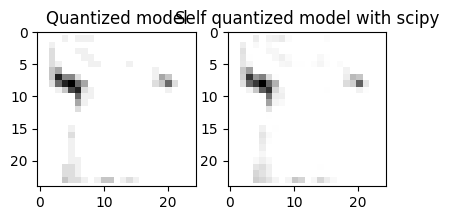

In [25]:
# Test outputs with quantization and NO post activation quantization
out_original = q_aware_model(train_images[np.newaxis,TARGET_IMAGE])

# Two part model output
out_3 = q_model_part1(train_images[np.newaxis,TARGET_IMAGE])
out_4 = q_model_part2(out_3)

# First layer
key = keys_list[0]

kernel = quantized[key][:,:,0,OUT_CHANNEL]
bias = bias_ints[OUT_CHANNEL]

# self_conv = sp.signal.correlate2d(foo_image, kernel, mode = "valid") + bias
self_conv = sp.signal.correlate2d(quantized_input_image[0] - input_zero, kernel, mode = "valid").astype(int) + bias
self_conv = np.maximum(0, self_conv)

self_conv_float = bias_scales_first_layer[OUT_CHANNEL]*self_conv
print(out_3[0,slicer,slicer,OUT_CHANNEL].numpy())
print(self_conv_float[slicer,slicer])

fig, ax = plt.subplots(1, 2, figsize = (4.5, 2))

ax[0].imshow(out_3[0,:,:,OUT_CHANNEL], cmap = 'Greys')
ax[0].set_title('Quantized model')
ax[0].axis('equal')
ax[0].set(xlim = (0, out.shape[1:3][0]), ylim = (out.shape[1:3][1], 0))

ax[1].imshow(self_conv_float[:,:], cmap = 'Greys')
ax[1].set_title('Self quantized model with scipy')
ax[1].axis('equal')
ax[1].set(xlim = (0, out.shape[1:3][0]), ylim = (out.shape[1:3][1], 0))
plt.show()
plt.close()


In [26]:
# Two part model output Test against quantized model with post activation quantization included
TARGET_IMAGE = 5300 #100
OUT_CHANNEL = 22 #20

(train_images_2, train_labels_2), (test_images_2, test_labels_2) = tf.keras.datasets.fashion_mnist.load_data()

quantized_input_image = np.round(train_images[TARGET_IMAGE]/input_scale).astype(int) + input_zero
quantized_and_dequantized_input = input_scale*(quantized_input_image - input_zero)

out_nq = nq_model_part1(train_images[np.newaxis,TARGET_IMAGE])
out_q = q_model_part1(train_images[np.newaxis,TARGET_IMAGE])

increment = 4
initial_x = 5
initial_y = 3
sub_pos_x = (initial_x, initial_x + increment)
sub_pos_y = (initial_y, initial_y + increment)
position = (0, slice(*sub_pos_y), slice(*sub_pos_x), OUT_CHANNEL)
# print("Original input")
# print(train_images[TARGET_IMAGE, slice(*sub_pos_y), slice(*sub_pos_x)])
# print("Quantized input")
# print(quantized_and_dequantized_input[slice(*sub_pos_y), slice(*sub_pos_x)])
print("Quantized model")
print(out_q[position].numpy())

# First layer
key = keys_list[0]
kernel = quantized[key][:,:,0]
bias = bias_ints
# print(kernel.shape)
# print(bias.shape)

conv_array = []
for channel in range(kernel.shape[-1]):
    self_conv = sp.signal.correlate2d(quantized_input_image - input_zero, kernel[:,:,channel], mode = "valid").astype(int) + bias[channel]
    self_conv = np.maximum(0, self_conv)
    float_conv = bias_scales_first_layer[channel]*self_conv
    conv_array.append(float_conv)
out_conv = np.array(conv_array)
out_conv = np.moveaxis(out_conv, 0, 2)

print("Self quantized model no activation")
print(out_conv[position[1:]])

print("Difference between original input no normalization and quantized input")
print(np.unique(train_images_2[TARGET_IMAGE] - (quantized_input_image - input_zero)))

out_conv_3 = out_conv
out_conv_3 = activation_scale * np.round(out_conv_3 / activation_scale)
print("Self quantized with activation")
print(out_conv_3[position[1:]])

Quantized model
[[0.         0.         0.13041282 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.0326032  0.         0.        ]
 [0.         0.22822243 0.         0.        ]]
Self quantized model no activation
[[0.         0.         0.14309532 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.03776719 0.         0.        ]
 [0.         0.21986756 0.         0.        ]]
Difference between original input no normalization and quantized input
[0]
Self quantized with activation
[[0.         0.         0.13041282 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.0326032  0.         0.        ]
 [0.         0.22822243 0.         0.        ]]


In [27]:
# Mixed model practice First part no bias, Second part with bias
input_layer = tf.keras.layers.Input(shape = (28, 28, 1))
conv_1_1 = tf.keras.layers.Conv2D(32, 5, use_bias = False, activation = None)(input_layer)
conv_1_1_2 = tf.keras.layers.Conv2D(32, 5, use_bias = True, activation = 'relu')(input_layer)

nq2_model_part1 = tf.keras.models.Model(inputs = input_layer, outputs = conv_1_1)
nq2_model2_part1 = tf.keras.models.Model(inputs = input_layer, outputs = conv_1_1_2)

In [28]:
print("Part 1 Summary")
for i, layer in enumerate(nq2_model_part1.layers):
    print(i, layer.name, len(layer.variables),"input", layer.input.shape, "output", layer.output.shape)

Part 1 Summary
0 input_3 0 input (None, 28, 28, 1) output (None, 28, 28, 1)
1 conv2d_3 1 input (None, 28, 28, 1) output (None, 24, 24, 32)


In [29]:
# Assignation of weights and testing mixed model
TARGET_IMAGE = 6300 #100
OUT_CHANNEL = 22 #20

q_idx_original_part1 = [1, 2]
q_idx_original_part2 = list(range(3, 9 + 1))
q_idx_new_part2 = list(range(3, 9 + 1))
# for i, layer in enumerate(q_aware_model.layers):
#     # layer.get_weights()
#     if len(layer.get_weights()) != 0:
#         print(i)
q_weights_1 = [q_aware_model.layers[idx].get_weights() for idx in q_idx_original_part1]
q_weights_2 = [q_aware_model.layers[idx].get_weights() for idx in q_idx_original_part2]
q_weights_1_1 = q_weights_1[1].pop(1)
# print(q_weights_1[1][1])
# print(q_weights_1_1)

key = keys_list[0]
kernel = quantized[key][:,:,0]
bias = bias_ints
nq2_model_part1.layers[1].set_weights([quantized[key]])
nq2_model2_part1.layers[1].set_weights([quantized[key], bias])
# print(nq2_model_part1.layers[1].variables[0])

semi_quantized_input_image = np.round(train_images[TARGET_IMAGE]/input_scale).astype(int)
quantized_input_image = np.round(train_images[TARGET_IMAGE]/input_scale).astype(int) + input_zero
quantized_and_dequantized_input = input_scale*(quantized_input_image - input_zero)

out_nq2 = nq2_model_part1(semi_quantized_input_image[np.newaxis,:])
out_nq22 = nq2_model2_part1(semi_quantized_input_image[np.newaxis,:])

self_conv = sp.signal.correlate2d(quantized_input_image - input_zero, kernel[:,:,OUT_CHANNEL], mode = "valid").astype(int)
self_activ = np.maximum(0, self_conv + bias[OUT_CHANNEL])

# out_q = q_model_part1(train_images[np.newaxis,TARGET_IMAGE])

increment = 4
initial_x = 5
initial_y = 3
sub_pos_x = (initial_x, initial_x + increment)
sub_pos_y = (initial_y, initial_y + increment)
position = (0, slice(*sub_pos_y), slice(*sub_pos_x), OUT_CHANNEL)
print("Non quantized model with quantized weights and quantized input")
print(out_nq2[position].numpy())
print("Self quantized")
print(self_conv[slice(*sub_pos_y), slice(*sub_pos_x)])
print("Self quantized with biases")
print(self_activ[slice(*sub_pos_y), slice(*sub_pos_x)])
print("Layers usage")
print(tf.nn.relu(tf.nn.bias_add(out_nq2, bias))[position].numpy())
print("Non quantized model 2 with quantized weights and biases and quantized input")
print(out_nq22[position].numpy())


Non quantized model with quantized weights and quantized input
[[-35042.   9846.  19631.  20150.]
 [-40184.  12607.  10848.  15334.]
 [-45388.  29371.   2536.   8055.]
 [-31863.  31451.   2903.   4584.]]
Self quantized
[[-35042   9846  19631  20150]
 [-40184  12607  10848  15334]
 [-45388  29371   2536   8055]
 [-31863  31451   2903   4584]]
Self quantized with biases
[[    0  6704 16489 17008]
 [    0  9465  7706 12192]
 [    0 26229     0  4913]
 [    0 28309     0  1442]]
Layers usage
[[    0.  6704. 16489. 17008.]
 [    0.  9465.  7706. 12192.]
 [    0. 26229.     0.  4913.]
 [    0. 28309.     0.  1442.]]
Non quantized model 2 with quantized weights and biases and quantized input
[[    0.  6704. 16489. 17008.]
 [    0.  9465.  7706. 12192.]
 [    0. 26229.     0.  4913.]
 [    0. 28309.     0.  1442.]]


In [30]:
print(activation_scale * np.round(bias_scales_first_layer[OUT_CHANNEL] * out_nq22[position].numpy() / activation_scale))
print(train_images[np.newaxis,TARGET_IMAGE].shape)
out_pt1 = q_model_part1(train_images[np.newaxis,TARGET_IMAGE])
print(out_pt1[position].numpy())
print(np.unique(activation_scale * np.round(bias_scales_first_layer * out_nq22.numpy() / activation_scale) - out_pt1.numpy()))

[[0.         0.06520641 0.13041282 0.13041282]
 [0.         0.06520641 0.06520641 0.09780961]
 [0.         0.22822243 0.         0.0326032 ]
 [0.         0.22822243 0.         0.        ]]
(1, 28, 28)
[[0.         0.06520641 0.13041282 0.13041282]
 [0.         0.06520641 0.06520641 0.09780961]
 [0.         0.22822243 0.         0.0326032 ]
 [0.         0.22822243 0.         0.        ]]
[-0.0326032  0.       ]


In [99]:
# Two part model output
TARGET_IMAGE = 6300 #100
OUT_CHANNEL = 22 #20

semi_quantized_input_image = np.round(train_images[TARGET_IMAGE]/input_scale).astype(int)
out_nq2 = nq2_model_part1(semi_quantized_input_image[np.newaxis,:])
out_nq2 = tf.nn.relu(tf.nn.bias_add(out_nq2, bias))
out_nq2 = activation_scale * np.round(bias_scales_first_layer * out_nq2 / activation_scale)
out_q4 = q_model_part2(out_nq2)

out_test = q_aware_model(train_images[np.newaxis,TARGET_IMAGE])

print(out_q4)
print(out_test)
print(np.unique(out_test - out_q4))

tf.Tensor(
[[7.1383256e-05 6.0325971e-07 1.9709682e-04 1.2281805e-06 9.9949563e-01
  1.5581294e-08 1.9709682e-04 1.0379360e-08 3.5062109e-05 1.8437242e-06]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[7.1383256e-05 6.0325971e-07 1.9709682e-04 1.2281805e-06 9.9949563e-01
  1.5581294e-08 1.9709682e-04 1.0379360e-08 3.5062109e-05 1.8437242e-06]], shape=(1, 10), dtype=float32)
[0.]


In [100]:
def mix_split_models_generator(q_aware_model : tf.keras.Model, quantized_weights: OrderedDict, keys_list: List):
    r""" Mixed model generation
    -
    Generates first model as non quantized and second model as quantized.
    - First
    - Second """
    INDEX_FIRST_LAYER_KEY_LIST = 1
    INDEX_FIRST_CONV_ORIGINAL_MODEL = 2
    INDEX_FIRST_CONV_PT1_MODEL = 1
    INDEX_QUANTIZE_LAYER_PT2_MODEL = 1
    PT2_LENGTH = len(q_aware_model.layers) - 3
    START_INDEX_ORIGINAL_MODEL_PT2 = 3
    START_INDEX_PT2_MODEL = 2

    input_layer = tf.keras.layers.Input(shape = (28, 28, 1))
    conv_1 = tf.keras.layers.Conv2D(32, 5, use_bias = False, activation = None)(input_layer)

    input_layer_2 = tf.keras.layers.Input(shape = (24, 24, 32))
    pool_1 = tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2)(input_layer_2)
    conv_2 = tf.keras.layers.Conv2D(64, 5, use_bias = True, activation = 'relu')(pool_1)
    pool_2 = tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2)(conv_2)
    conv_3 = tf.keras.layers.Conv2D(96, 3, use_bias = True, activation = 'relu')(pool_2)
    pool_3 = tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2)(conv_3)
    flat_1 = tf.keras.layers.Flatten()(pool_3)
    dense_out = tf.keras.layers.Dense(10, activation = 'softmax', name = "dense_last")(flat_1)

    # First model: non-quantized with quantized weights
    nq_model_part1 = tf.keras.models.Model(inputs = input_layer, outputs = conv_1)
    # Second model: quantized
    nq_model_part2 = tf.keras.models.Model(inputs = input_layer_2, outputs = dense_out)
    q_model_part2 = tfmot.quantization.keras.quantize_model(nq_model_part2)

    # Assignation of values for the part 1 model
    key = keys_list[INDEX_FIRST_LAYER_KEY_LIST]
    nq_model_part1.layers[INDEX_FIRST_CONV_PT1_MODEL].set_weights([quantized_weights[key]])
    
    # Assignation of max and min values for quantization layer for part 2 model
    indexes_original_part2 = list(range(START_INDEX_ORIGINAL_MODEL_PT2, START_INDEX_ORIGINAL_MODEL_PT2 + PT2_LENGTH))
    indexes_new_part2 = list(range(START_INDEX_PT2_MODEL, START_INDEX_PT2_MODEL + PT2_LENGTH))
    quantize_layer_max_min = q_aware_model.layers[INDEX_FIRST_CONV_ORIGINAL_MODEL].get_weights()[-2:]
    quantize_layer_max_min.append(-1)
    q_model_part2.layers[INDEX_QUANTIZE_LAYER_PT2_MODEL].set_weights(quantize_layer_max_min)
    # Assignation of the rest of the values for the rest of the part 2 model
    weights_part2_model = [q_aware_model.layers[idx].get_weights() for idx in indexes_original_part2]
    for i, idx in enumerate(indexes_new_part2):
        q_model_part2.layers[idx].set_weights(weights_part2_model[i])

    q_model_part2.compile(optimizer = 'adam', 
        loss = 'sparse_categorical_crossentropy', 
        metrics = ['accuracy'])

    return nq_model_part1, q_model_part2

In [101]:
# Two part model output
TARGET_IMAGE = 1 #100

model_pt1_nq, model_pt2_q = mix_split_models_generator(q_aware_model, quantized_weights, new_keys_list)

semi_quantized_input_image = np.round(train_images[TARGET_IMAGE]/output_scales[new_keys_list[0]]).astype(int)
out_pt1 = model_pt1_nq(semi_quantized_input_image[np.newaxis,:])
out_pt1 = tf.nn.relu(tf.nn.bias_add(out_pt1, bias))
out_pt1 = activation_scale * np.round(bias_scales_first_layer * out_pt1 / activation_scale)
out_pt2 = q_model_part2(out_pt1)

out_test = q_aware_model(train_images[np.newaxis,TARGET_IMAGE])

print("Out part 2")
print(out_pt2)
print("Out test")
print(out_test)
print("Unique Differences", np.unique(out_test - out_pt2))

Out part 2
tf.Tensor(
[[9.9998820e-01 7.6681560e-12 3.3928120e-06 2.9688740e-10 1.0043667e-09
  7.6681560e-12 8.4632084e-06 7.6681560e-12 6.9175248e-09 7.6681569e-12]], shape=(1, 10), dtype=float32)
Out test
tf.Tensor(
[[9.9998820e-01 7.6681560e-12 3.3928120e-06 2.9688740e-10 1.0043667e-09
  7.6681560e-12 8.4632084e-06 7.6681560e-12 6.9175248e-09 7.6681569e-12]], shape=(1, 10), dtype=float32)
Unique Differences [0.]


In [102]:
LAYER = 1
TARGET = 7904

key = new_keys_list[LAYER]
semi_quantized_test_images = np.round(test_images/output_scales[new_keys_list[0]]).astype(int)
out_test_part1 = model_pt1_nq.predict(semi_quantized_test_images)
print(np.max(out_test_part1))
print(np.min(out_test_part1))
dequantized_out_test_part1 = output_scales[key] * np.round(bias_scales[key] * tf.nn.relu(tf.nn.bias_add(out_test_part1, quantized_bias[key])) / output_scales[key])

out_test_part2 = model_pt2_q.predict(dequantized_out_test_part1)
out_test = q_aware_model.predict(test_images)
print(out_test_part2[TARGET])
print(out_test[TARGET])
diff = np.unique(out_test_part2 - out_test)
m = np.maximum(np.abs(np.max(diff)), np.abs(np.min(diff)))
# print(diff)
print("All set difference", m)
print("Quantity differences", len(diff))
print("Target difference", np.max(np.unique(out_test_part2[TARGET] - out_test[TARGET])))
eps = 1e-2
print("Location", np.where(np.abs(diff -np.max(diff)) < eps))

313/313 [==============================] - 1s 2ms/step
182375.0
-198187.0
313/313 [==============================] - 2s 6ms/step
[1.6090614e-04 9.9974769e-01 2.5010963e-06 1.7836649e-07 5.0920039e-06
 4.9320692e-10 4.6002378e-06 4.9320692e-10 7.9033991e-05 3.0688772e-09]
[1.6090614e-04 9.9974769e-01 2.5010963e-06 1.7836649e-07 5.0920039e-06
 4.9320692e-10 4.6002378e-06 4.9320692e-10 7.9033991e-05 3.0688772e-09]
All set difference 0.05063927
Quantity differences 7905
Target difference 0.0
Location (array([7903, 7904], dtype=int64),)


In [103]:
part2_test_loss, part2_test_acc = model_pt2_q.evaluate(dequantized_out_test_part1, test_labels)
print('Part 2 test accuracy : ', "{:0.2%}".format(part2_test_acc))
print('Part 2 test loss: ', part2_test_loss)
q_aware_test_loss, q_aware_test_acc = q_aware_model.evaluate(test_images, test_labels)
print('Q Aware model test accuracy : ', "{:0.2%}".format(q_aware_test_acc))
print('Q Aware model test loss: ', q_aware_test_loss)

313/313 [==============================] - 2s 5ms/step - loss: 0.2892 - accuracy: 0.9116
Part 2 test accuracy :  91.16%
Part 2 test loss:  0.2891831398010254
313/313 [==============================] - 2s 7ms/step - loss: 0.2891 - accuracy: 0.9115
Q Aware model test accuracy :  91.15%
Q Aware model test loss:  0.2890910804271698


In [104]:
x = -194204
y = n_bit_flipper(x, bit_width = 32, bit_pos = 21)
print(y)

-2291356


In [187]:
# test_images[:,:,:,np.newaxis].shape
# Input layer
a = q_aware_model.layers[0](test_images[:,:,:,np.newaxis])
# Quantize layer
b = q_aware_model.layers[1](a)
# Convolutional layer
c = q_aware_model.layers[2](b)
print(b.shape)
pos = 0, slice(10,15), slice(10,15), 0

input_scale = ((input_max - input_min) / (2**BIT_WIDTH - 1)).astype(np.float32)
# kernel_scales = kernel_max / (2**(BIT_WIDTH - 1) - 1)
# bias_scales_first_layer = input_scale * kernel_scales
print((input_scale * kernel_scales).dtype)
activation_scale = ((activation_max - activation_min) / (2**BIT_WIDTH - 1)).astype(np.float32)

print("input scale", input_scale, input_scale.dtype)
print("activation scale", activation_scale, activation_scale.dtype)
print("after quantization input", b.dtype)
print("kernel scales", kernel_scales.dtype)
print("kernel quantized", (kernel_scales*quantized[keys_list[0]]).dtype)
b_2 = tf.nn.conv2d(b, kernel_scales*quantized[keys_list[0]], strides = 1, padding = "VALID")
print("after convolution", b_2.dtype)
b_2_bias = tf.nn.bias_add(b_2, (input_scale*kernel_scales).astype(np.float32)*bias_ints)
print("after bias", b_2_bias.dtype)
b_2_relu = tf.nn.relu(b_2_bias)
print("after relu", b_2_relu.dtype)
print("division", (b_2_relu / activation_scale).dtype)
deq_out_test_part1 = activation_scale * np.round(b_2_relu / activation_scale)
print("dequantized", deq_out_test_part1.dtype)

print("input division", np.unique(semi_quantized_input_image - np.round((train_images[:,:,:,np.newaxis]/input_scale).astype(np.float32))))
semi_quantized_test_images = np.round(test_images[:,:,:,np.newaxis]/input_scale).astype(int)
dequant = input_scale * semi_quantized_test_images

b_2_quant = tf.nn.conv2d(semi_quantized_test_images, quantized[keys_list[0]], strides = 1, padding = "VALID")
b_2_quant_bias = tf.nn.bias_add(b_2_quant, bias_ints) 
b_2_quant_relu = tf.nn.relu(b_2_quant_bias)
b_2_dequant = activation_scale * np.round( input_scale * kernel_scales* tf.cast(b_2_quant_relu, np.float32) / activation_scale)

# print(test_images[pos[:-1]])
# print(b[pos])
diff_quantized_input, quantized_input_counts = np.unique(dequant - b, return_counts = True)
diff_dequantized_output, dequantized_output_counts = np.unique(c - deq_out_test_part1, return_counts = True)
diff_dequant_ints_output, dequant_ints_output_counts = np.unique(c - b_2_dequant, return_counts = True)
print("Difference after input quantize layer", diff_quantized_input, quantized_input_counts)
print("Difference after convolution layer", diff_dequantized_output, dequantized_output_counts)
print("Difference after convolution layer ints", diff_dequant_ints_output, dequant_ints_output_counts)

(10000, 28, 28, 1)
float32
input scale 0.003921569 float32
activation scale 0.032603204 float32
after quantization input <dtype: 'float32'>
kernel scales float32
kernel quantized float32
after convolution <dtype: 'float32'>
after bias <dtype: 'float32'>
after relu <dtype: 'float32'>
division <dtype: 'float32'>
dequantized float32
input division [0.]
Difference after input quantize layer [0.] [7840000]
Difference after convolution layer [-0.03260326 -0.0326032   0.          0.03260314  0.0326032 ] [        1      2636 184312977        34      4352]
Difference after convolution layer ints [-0.03260326 -0.0326032   0.          0.03260314  0.0326032 ] [        1      2640 184312972        34      4353]


In [153]:
print("Difference after convolution layer", diff_dequantized_output, dequantized_output_counts)

Difference after convolution layer [-0.03260326 -0.0326032   0.          0.03260314  0.0326032 ] [        1      2636 184312977        34      4352]


In [186]:
print(semi_quantized_test_images[pos])
print(tf.cast(b_2_quant_relu, np.float32)[pos])

[[  0   0   0   4   0]
 [  0   0   2   0  11]
 [  0   3   0   0 115]
 [  3   0   0  89 139]
 [  0   0  98 136 110]]
tf.Tensor(
[[3216.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.  445.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]], shape=(5, 5), dtype=float32)
